# Checking pyaerocom installation and access to data

## Import pyaerocom

It all begins with an import:

In [1]:
import pyaerocom as pya
pya.__version__

'0.10.0rc2'

## Check available datasets and directories

Accessible data and default paths for certain datasets are available (and can be updated via the `const` module).

In [2]:
pya.const

### Data search directories

In [3]:
pya.const.DATA_SEARCH_DIRS

[]

This list contains all directories where pyaerocom will search for model and observation data. pyaerocom will search for both model and observation data in all directories that are specified here. Searching can be done using and if nothing can be found for a certain query, an Exception is raised. Let's try to find some data from the [TM5](http://tm5.sourceforge.net/) chemistry-transport-model:

In [4]:
try:
    pya.browse_database('*TM5*')
except pya.exceptions.DataSearchError as e:
    print(e)

No matches could be found for search pattern *TM5*


Well, that's expected as no data search directories are specified (and most likely, no TM5 data is available on whatever which machine this notebook is executed). Let's make this a little more interesting. We need some data!

## Downloading the pyaerocom testdata-minimal dataset

The testdata-minimal dataset was developed for automatic testing of pyaerocom and is well suited to illustrate the main features of pyaerocom, without too requiring too heavy computing resources or data storage. It is very easy to get these data:

In [5]:
from pyaerocom.testdata_access import TestDataAccess
TestDataAccess().download()

True

Now we have a path, where there is supposed to be some data. Awesomeness!

In [6]:
dataloc = f'{pya.const.HOMEDIR}MyPyaerocom/testdata-minimal/'
dataloc

'/home/jonasg/MyPyaerocom/testdata-minimal/'

Side comment: If this way of formatting python strings looks weird to you, don't worry, this is because it is a [rather new feature](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/) (as of Nov 2020).

In [7]:
import os
os.listdir(dataloc)

['README.md', 'scripts', 'coldata', 'obsdata', 'modeldata', 'config']

Let's look into the modeldata directory (obsdata follows later).

In [8]:
os.listdir(dataloc + 'modeldata')

['EMEP_2017', 'TM5-met2010_CTRL-TEST']

### Adding data search directories

Great, found something. Let's tell pyaerocom about it.

In [9]:
pya.const.add_data_search_dir(dataloc + 'modeldata')

Now, let's repeat what we did before.

In [10]:
pya.const.DATA_SEARCH_DIRS

['/home/jonasg/MyPyaerocom/testdata-minimal/modeldata']

In [11]:
pya.browse_database('*TM5*')


Pyaerocom ReadGridded
---------------------
Data ID: TM5-met2010_CTRL-TEST
Data directory: /home/jonasg/MyPyaerocom/testdata-minimal/modeldata/TM5-met2010_CTRL-TEST/renamed
Available experiments: ['AP3']
Available years: [2010]
Available frequencies ['daily' 'monthly']
Available variables: ['abs550aer', 'od550aer']


['TM5-met2010_CTRL-TEST']

Nice! This worked, and there is even a lot of additional information, that comes in handy. The latter is because the underlying NetCDF files in the data directory are stored using AeroCom file naming conventions. Each dataset has it's own ID (usually the directory name and can be accessed via this ID). For this example TM5 dataset the ID is *TM5-met2010_CTRL-TEST* as can be seen in the output from the browsing method.

pyaerocom makes extensive use og these conventions, which makes it easy to streamline analyses of many different models and observation records. However, as we shall see below, the latter are often formatted in many different ways, as observations from many different databases are used. 

In [12]:
reader = pya.io.ReadGridded('TM5-met2010_CTRL-TEST')
reader


Pyaerocom ReadGridded
---------------------
Data ID: TM5-met2010_CTRL-TEST
Data directory: /home/jonasg/MyPyaerocom/testdata-minimal/modeldata/TM5-met2010_CTRL-TEST/renamed
Available experiments: ['AP3']
Available years: [2010]
Available frequencies ['daily' 'monthly']
Available variables: ['abs550aer', 'od550aer']

### Tiny detour: AeroCom file naming conventions

Let's have a brief look at such a filename (taking the first file in the data directory):

In [13]:
first_file = reader.files[0]
os.path.basename(first_file)

'aerocom3_TM5-met2010_AP3-CTRL2019_abs550aer_Column_2010_daily.nc'

The template is:

`
aerocom3_<ModelName>-<MeteoConfigSpecifier>_<ExperimentName>-<PerturbationName>_<VariableName>_<VerticalCoordinateType>_<Period>_<Frequency>.nc
`

So the above filename uses **TM5** model, 2010 meteorology (**met2010**), and this version is for AeroCom Phase III (**AP3**) experiment, particularly for the 2019 Control (**CTRL2019**) perturbation. Variable is **abs550aer** (which is the aerosol absorption optical depth, or AAOD), which is representative for a whole atmospheric **Column**, the simulated year is **2010** (here it is the same as meteorology, but this must not always be the case) and the temporal resolution is **daily**.

If you want to learn more about AeroCom conventions and ongoing experiments, [see here](https://docs.google.com/spreadsheets/d/1NiHLVTDsBo0JEBSnnDECNI2ojUnCVlxuy2PFrsRJW38/edit#gid=1475397852).

The metadata that is extracted from the filenames is accessible via:

In [14]:
reader.file_info

,var_name,year,ts_type,vert_code,data_id,name,meteo,experiment,perturbation,is_at_stations,3D,filename
0,abs550aer,2010,daily,Column,TM5-met2010_CTRL-TEST,TM5,met2010,AP3,CTRL2019,False,False,aerocom3_TM5-met2010_AP3-CTRL2019_abs550aer_Co...
3,abs550aer,2010,monthly,Column,TM5-met2010_CTRL-TEST,TM5,met2010,AP3,CTRL2019,False,False,aerocom3_TM5-met2010_AP3-CTRL2019_abs550aer_Co...
1,od550aer,2010,daily,Column,TM5-met2010_CTRL-TEST,TM5,met2010,AP3,CTRL2019,False,False,aerocom3_TM5-met2010_AP3-CTRL2019_od550aer_Col...
2,od550aer,2010,monthly,Column,TM5-met2010_CTRL-TEST,TM5,,AP3,CTRL2016,False,False,aerocom3_TM5_AP3-CTRL2016_od550aer_Column_2010...


### How do I know what the variable names mean?

You can check all variables via `pyaerocom.const.VARS`, which is a dictionary-like object that allows access to variables and in most cases, provides relevant additional information such as the [CF standard_name](https://cfconventions.org/standard-names.html). For instance, for the above `abs550aer`:

In [15]:
var = pya.const.VARS['abs550aer']
var

abs550aer
standard_name: atmosphere_absorption_optical_thickness_due_to_ambient_aerosol_particles; Unit: 1

In [16]:
var.long_name

'Absorption aerosol optical thickness at 550nm'

Or the extinction (scattering + absorption) aerosol optical depth (AOD), called `od550aer`:

In [17]:
var = pya.const.VARS['od550aer']
var

od550aer
standard_name: atmosphere_optical_thickness_due_to_ambient_aerosol_particles; Unit: 1

### Reading of model data using `ReadGridded` class

The above instantiated `ReadGridded` interface relies on and makes use of these conventions. This class is also the standard interface to read the modeldata into instances of the `pyaerocom.GriddedData`

In [18]:
aaod_tm5 = reader.read_var('abs550aer', start=2010, ts_type='monthly')
aaod_tm5

pyaerocom.GriddedData
Grid data: <iris 'Cube' of atmosphere_absorption_optical_thickness_due_to_ambient_aerosol / (1) (time: 12; latitude: 90; longitude: 120)>

Under the hood, the `GriddedData` object is an [iris.Cube](https://scitools.org.uk/iris/docs/latest/userguide/iris_cubes.html), and it is **single variable**, that is, it does not support reading of multiple variable fields (e.g. AOD and AAOD sharing the same lat, lon and time dimensions). 

The `GriddedData` object is introduced in more detail in other tutorials, but what is a tutorial without a nice, self-explanatory plot anyways?

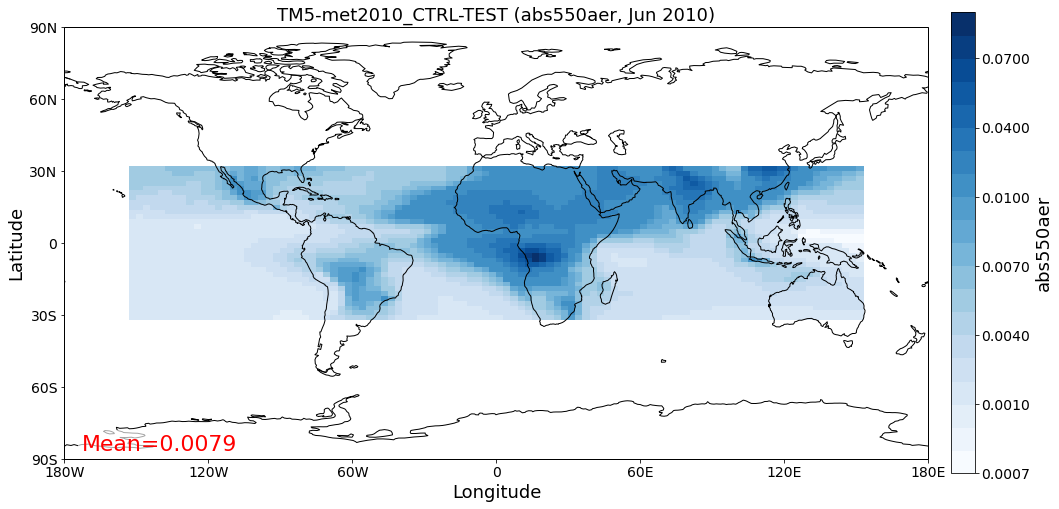

In [19]:
aaod_tm5.sel(latitude=(-30, 30), longitude=(-150, 150)).quickplot_map('06/2010');

## Registering and reading of *ungridded* observational data

### ... COMING VERY SOON!!! Until then, check the old tutorials!